In [1]:
#https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# import the necessary packages
import os

# initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = "Food-11.zip"

# initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
#BASE_PATH = "dataset1"
import tempfile
TEMPDIR = tempfile.gettempdir()
BASE_PATH = os.path.join(TEMPDIR, "dataset1.zip")

# define the names of the training, testing, and validation
# directories
TRAIN = "training1"
TEST = "evaluation1"
VAL = "validation1"

# initialize the list of class label names
CLASSES = ["Bread", "Dairy product", "Dessert", "Egg", "Fried food","Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup","Vegetable/Fruit"]

# set the batch size when fine-tuning
BATCH_SIZE = 5 #32, small batch size for 3GB NVIDIA GeForce 1060 3GB

# initialize the label encoder file path and the output directory to
# where the extracted features (in CSV file format) will be stored
#LE_PATH = os.path.sep.join(["output1", "le.cpickle"])
#BASE_CSV_PATH = "output1"

LE_PATH = os.path.sep.join([TEMPDIR, "le1.cpickle"])
BASE_CSV_PATH = TEMPDIR

# set the path to the serialized model after training
#MODEL_PATH = os.path.sep.join(["output1", "food11.model"])
MODEL_PATH = os.path.sep.join([TEMPDIR, "food11.model"])

# define the path to the output training history plots
#UNFROZEN_PLOT_PATH = os.path.sep.join(["output1", "unfrozen.png"])
#WARMUP_PLOT_PATH = os.path.sep.join(["output1", "warmup.png"])
UNFROZEN_PLOT_PATH = os.path.sep.join([TEMPDIR, "unfrozen.png"])
WARMUP_PLOT_PATH = os.path.sep.join([TEMPDIR, "warmup.png"])

In [3]:
# import the necessary packages
from imutils import paths
import shutil
import os
# import the necessary packages
from keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle

Using TensorFlow backend.


In [4]:
import zipfile
import cv2
zf = zipfile.ZipFile(ORIG_INPUT_DATASET)
imagelist = zf.namelist()

ozf = zipfile.ZipFile(BASE_PATH, 'w')

classcountdict = {}

# loop over the data splits
for split in (TRAIN, TEST, VAL):
	# grab all image paths in the current split
	print("[INFO] processing '{} split'...".format(split))
	#p = os.path.sep.join([ORIG_INPUT_DATASET, split])
	#imagePaths = list(paths.list_images(p))
	imagePaths = [ix for ix in imagelist if ix.startswith(split)]

	# loop over the image paths
	for imagePath in imagePaths:
		# extract class label from the filename
		#filename = imagePath.split(os.path.sep)[-1]
		#label = CLASSES[int(filename.split("_")[0])]
		filename = imagePath.rsplit('/', 1)[-1]
		label = CLASSES[int(filename.split("_")[0])]
		classcountdict.setdefault(label, 0)
		classcountdict[label] += 1

		# construct the path to the output directory
		dirPath = os.path.sep.join([BASE_PATH, split, label])
		dirPath = '/'.join([split, label])

		# if the output directory does not exist, create it
		#if not os.path.exists(dirPath):
		#	os.makedirs(dirPath)

		# construct the path to the output image file and copy it
		#p = os.path.sep.join([dirPath, filename])
		#shutil.copy2(imagePath, p)
		ozf.writestr(dirPath + '/' + filename, zf.read(imagePath), compress_type=zipfile.ZIP_STORED)
	#print(len(imagePaths))
zf.close()
ozf.close()

[INFO] processing 'training1 split'...
[INFO] processing 'evaluation1 split'...
[INFO] processing 'validation1 split'...


In [5]:
print(CLASSES)
print([classcountdict[ix] for ix in CLASSES])

['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']
[1724, 721, 2500, 1648, 1461, 2206, 734, 472, 1505, 2500, 1172]


In [27]:
def plot_training(H, N, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [7]:
# derive the paths to the training, validation, and testing directories
#trainPath = os.path.sep.join([BASE_PATH, TRAIN])
#valPath = os.path.sep.join([BASE_PATH, VAL])
#testPath = os.path.sep.join([BASE_PATH, TEST])

# determine the total number of image paths in training, validation,
# and testing directories
#totalTrain = len(list(paths.list_images(trainPath)))
#totalVal = len(list(paths.list_images(valPath)))
#totalTest = len(list(paths.list_images(testPath)))

from keras.applications import imagenet_utils
import cv2
zf = zipfile.ZipFile(BASE_PATH)
imagelist = zf.namelist()
#print(len(imagelist))
#print(imagelist[:5])

imageTrain = []
imageVal = []
imageTest = []
labelTrain = []
labelVal = []
labelTest = []

#print(TRAIN, TEST, VAL)

# loop over the data splits
for split in (TRAIN, TEST, VAL):
	# grab all image paths in the current split
	print("[INFO] processing '{} split'...".format(split))
	#p = os.path.sep.join([BASE_PATH, split])
	#imagePaths = list(paths.list_images(p))
	imagePaths = [ix for ix in imagelist if ix.startswith(split)]
	# loop over the images in batches
	#print(split, len(imagePaths))
	print("[INFO] processing '{} images'...".format(len(imagePaths)))
	for imagePath in imagePaths:
		# load the input image using the Keras helper utility
		# while ensuring the image is resized to 224x224 pixels
		#image = load_img(imagePath, target_size=(224, 224))
		#image = img_to_array(image)
		#print(imagePath)
		image = cv2.imdecode(np.frombuffer(zf.read(imagePath), np.uint8), 1)
		image = cv2.resize(image, (224, 224))
		image = np.expand_dims(image, axis=0)
		image = imagenet_utils.preprocess_input(image)
		label, filename = imagePath.rsplit('/', 1)
		imageclass, label = label.split('/', 1)
		if imageclass == TRAIN:
			imageTrain.append(image)
			labelTrain.append(CLASSES.index(label))
		if imageclass == VAL:
			imageVal.append(image)
			labelVal.append(CLASSES.index(label))
		if imageclass == TEST:
			imageTest.append(image)
			labelTest.append(CLASSES.index(label))
	print(imageclass, len(imagePaths))
	print(imageclass, len(imagePaths))
	#if imageclass == TRAIN: imageTrain = np.vstack(imageTrain)
	#if imageclass == VAL: imageVal = np.vstack(imageVal)
	#if imageclass == TEST: imageTest = np.vstack(imageTest)
zf.close()
imageTrain = np.vstack(imageTrain)
imageVal = np.vstack(imageVal)
imageTest = np.vstack(imageTest)
from tensorflow.keras.utils import to_categorical
labelTrain = to_categorical(labelTrain)
labelVal = to_categorical(labelVal)
labelTest = to_categorical(labelTest)
print(split, len(imageTrain), len(imageVal), len(imageTest))
print(split, len(labelTrain), len(labelVal), len(labelTest))

[INFO] processing 'training1 split'...
[INFO] processing '9866 images'...
training1 9866
training1 9866
[INFO] processing 'evaluation1 split'...
[INFO] processing '3347 images'...
evaluation1 3347
evaluation1 3347
[INFO] processing 'validation1 split'...
[INFO] processing '3430 images'...
validation1 3430
validation1 3430
validation1 9866 3430 3347
validation1 9866 3430 3347


In [8]:
#imageTrain = np.vstack(imageTrain)
#imageVal = np.vstack(imageVal)
#imageTest = np.vstack(imageTest)
print(labelTrain[:5])
print(labelVal[:5])
print(labelTest[:5])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [9]:
print(imageTrain.shape)
print(imageVal.shape)
print(imageTest.shape)
print(len(imageTrain))
print(len(imageVal))
print(len(imageTest))

(9866, 224, 224, 3)
(3430, 224, 224, 3)
(3347, 224, 224, 3)
9866
3430
3347


In [10]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=30,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

In [11]:
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

In [12]:
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [13]:
# initialize the training generator
#trainGen = trainAug.flow_from_directory(trainPath,class_mode="categorical",target_size=(224, 224),color_mode="rgb",shuffle=True,batch_size=BATCH_SIZE)
trainGen = trainAug.flow(imageTrain, y = labelTrain, shuffle=True,batch_size=BATCH_SIZE)

In [14]:
# initialize the validation generator
#valGen = valAug.flow_from_directory(valPath,class_mode="categorical",target_size=(224, 224),color_mode="rgb",shuffle=False,batch_size=BATCH_SIZE)
valGen = valAug.flow(imageVal, y = labelVal, shuffle=False,batch_size=BATCH_SIZE)

In [15]:
# initialize the testing generator
#testGen = valAug.flow_from_directory(testPath,class_mode="categorical",target_size=(224, 224),color_mode="rgb",shuffle=False,batch_size=BATCH_SIZE)
testGen = valAug.flow(imageTest, y = labelTest, shuffle=False,batch_size=BATCH_SIZE)

In [16]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [17]:
print(baseModel.output.shape)

(None, 7, 7, 512)


In [18]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)

In [19]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [20]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [21]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [23]:
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
totalTrain = len(imageTrain)
totalVal = len(imageVal)
totalTest = len(imageTest)
print("[INFO] training head...")
H = model.fit_generator(trainGen,steps_per_epoch=totalTrain // BATCH_SIZE,validation_data=valGen,validation_steps=totalVal // BATCH_SIZE,epochs=50)
# TOO LONG CALCULATIOIN TIME

[INFO] training head...
Epoch 1/50
1973/1973 [==============================] - 281s 142ms/step - loss: 3.3569 - accuracy: 0.3314 - val_loss: 0.2865 - val_accuracy: 0.5175
Epoch 2/50
1973/1973 [==============================] - 276s 140ms/step - loss: 1.8131 - accuracy: 0.4072 - val_loss: 0.1556 - val_accuracy: 0.5487
Epoch 3/50
1973/1973 [==============================] - 231s 117ms/step - loss: 1.6714 - accuracy: 0.4663 - val_loss: 0.3971 - val_accuracy: 0.6224
Epoch 4/50
1973/1973 [==============================] - 229s 116ms/step - loss: 1.6098 - accuracy: 0.4916 - val_loss: 0.1192 - val_accuracy: 0.6487
Epoch 5/50
1973/1973 [==============================] - 244s 124ms/step - loss: 1.5328 - accuracy: 0.5134 - val_loss: 0.1107 - val_accuracy: 0.6528
Epoch 6/50
1973/1973 [==============================] - 232s 118ms/step - loss: 1.4669 - accuracy: 0.5385 - val_loss: 0.3173 - val_accuracy: 0.6889
Epoch 7/50
1973/1973 [==============================] - 253s 128ms/step - loss: 1.4102 -

[INFO] evaluating after fine-tuning network head...


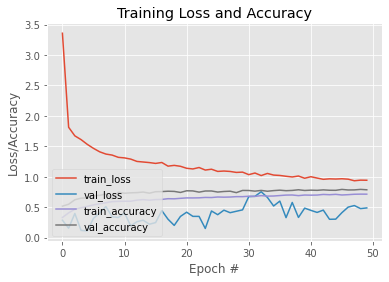

In [28]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = model.predict_generator(testGen,steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
#print(classification_report(testGen.classes, predIdxs,target_names=testGen.class_indices.keys()))
plot_training(H, 50, WARMUP_PLOT_PATH)

In [29]:
# reset our data generators
trainGen.reset()
valGen.reset()

In [30]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[15:]:
	layer.trainable = True

In [31]:
# loop over the layers in the model and show which ones are trainable
# or not
for layer in baseModel.layers:
	print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x0000014CE842EF10>: False
<keras.layers.convolutional.Conv2D object at 0x0000014CBF697910>: False
<keras.layers.convolutional.Conv2D object at 0x0000014C9BF68FD0>: False
<keras.layers.pooling.MaxPooling2D object at 0x0000014CE7586730>: False
<keras.layers.convolutional.Conv2D object at 0x0000014CBFCF9AC0>: False
<keras.layers.convolutional.Conv2D object at 0x0000014CE842E820>: False
<keras.layers.pooling.MaxPooling2D object at 0x0000014C9BF4F760>: False
<keras.layers.convolutional.Conv2D object at 0x0000014CE8316DF0>: False
<keras.layers.convolutional.Conv2D object at 0x0000014C9BF56460>: False
<keras.layers.convolutional.Conv2D object at 0x0000014CE82F3850>: False
<keras.layers.pooling.MaxPooling2D object at 0x0000014CE82F3460>: False
<keras.layers.convolutional.Conv2D object at 0x0000014CE8300B20>: False
<keras.layers.convolutional.Conv2D object at 0x0000014CE8300820>: False
<keras.layers.convolutional.Conv2D object at 0x0000014CE8309FA

In [32]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] re-compiling model...


In [33]:
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
H = model.fit_generator(trainGen,steps_per_epoch=totalTrain // BATCH_SIZE,validation_data=valGen,validation_steps=totalVal // BATCH_SIZE,epochs=20)

Epoch 1/20
1973/1973 [==============================] - 169s 86ms/step - loss: 1.5671 - accuracy: 0.5218 - val_loss: 0.0982 - val_accuracy: 0.6904
Epoch 2/20
1973/1973 [==============================] - 166s 84ms/step - loss: 1.0680 - accuracy: 0.6826 - val_loss: 0.4217 - val_accuracy: 0.7513
Epoch 3/20
1973/1973 [==============================] - 166s 84ms/step - loss: 0.9068 - accuracy: 0.7343 - val_loss: 0.4282 - val_accuracy: 0.8114
Epoch 4/20
1973/1973 [==============================] - 166s 84ms/step - loss: 0.7791 - accuracy: 0.7677 - val_loss: 0.5138 - val_accuracy: 0.8122
Epoch 5/20
1973/1973 [==============================] - 165s 84ms/step - loss: 0.7302 - accuracy: 0.7864 - val_loss: 0.5617 - val_accuracy: 0.8397
Epoch 6/20
1973/1973 [==============================] - 163s 82ms/step - loss: 0.6280 - accuracy: 0.8117 - val_loss: 0.1424 - val_accuracy: 0.8402
Epoch 7/20
1973/1973 [==============================] - 162s 82ms/step - loss: 0.5710 - accuracy: 0.8295 - val_loss: 0

[INFO] evaluating after fine-tuning network...


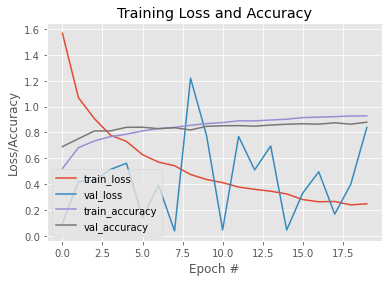

In [34]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating after fine-tuning network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
#print(classification_report(testGen.classes, predIdxs,target_names=testGen.class_indices.keys()))
plot_training(H, 20, UNFROZEN_PLOT_PATH)

In [35]:
# serialize the model to disk
print("[INFO] serializing network...")
model.save(MODEL_PATH)

[INFO] serializing network...


In [36]:
import zipfile
import cv2
zf = zipfile.ZipFile(BASE_PATH)
imagelist = zf.namelist()

# load the input image and then clone it so we can draw on it later
#image = cv2.imread(args["image"])
imagename = 'evaluation1/Dessert/2_100.jpg'
image = cv2.imdecode(np.frombuffer(zf.read(imagename), np.uint8), 1)

#output = image.copy()
#output = imutils.resize(output, width=400)

output = imutils.resize(image, width=400)

In [37]:
# our model was trained on RGB ordered images but OpenCV represents
# images in BGR order, so swap the channels, and then resize to
# 224x224 (the input dimensions for VGG16)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))

In [38]:
# convert the image to a floating point data type and perform mean
# subtraction
image = image.astype("float32")
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
image -= mean

In [39]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model(MODEL_PATH)

[INFO] loading model...


In [40]:
# pass the image through the network to obtain our predictions
preds = model.predict(np.expand_dims(image, axis=0))[0]
i = np.argmax(preds)
label = CLASSES[i]

In [41]:
# draw the prediction on the output image
text = "{}: {:.2f}%".format(label, preds[i] * 100)
cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

array([[[ 12,  12,  18],
        [ 13,  13,  19],
        [ 14,  14,  20],
        ...,
        [ 10,  11,  15],
        [ 11,  12,  16],
        [ 11,  12,  16]],

       [[ 13,  13,  19],
        [ 14,  14,  20],
        [ 14,  14,  20],
        ...,
        [ 10,  11,  15],
        [ 10,  11,  15],
        [ 11,  12,  16]],

       [[ 14,  14,  20],
        [ 14,  14,  20],
        [ 14,  14,  20],
        ...,
        [ 10,  11,  15],
        [ 10,  11,  15],
        [ 10,  11,  15]],

       ...,

       [[122, 131, 145],
        [137, 146, 160],
        [132, 141, 155],
        ...,
        [100, 102, 110],
        [100, 102, 110],
        [ 99, 101, 109]],

       [[127, 136, 150],
        [134, 143, 157],
        [139, 148, 162],
        ...,
        [100, 102, 110],
        [ 99, 101, 109],
        [ 99, 101, 109]],

       [[128, 137, 151],
        [129, 138, 152],
        [139, 148, 162],
        ...,
        [100, 102, 110],
        [ 99, 101, 109],
        [ 99, 101, 109]]

In [42]:
# show the output image
cv2.imshow("Output", output)
cv2.waitKey(0)

-1